**CPLEX installation guide:** Add following line to your `.bash_profile` (for macOS) after installing IBM ILOG CPLEX Optimization Studio locally using installer from IBM. (note the path will change if you are using different python or OS)

```export PYTHONPATH="/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx"```

In [1]:
import cplex
print(cplex.__path__)  # make sure the path is the one we pick above

['C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio1210\\cplex\\python\\3.7\\x64_win64\\cplex']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

## Parameters

In [3]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
path_init_conf =     '../output/m18-improved.csv'
path_dump_improved = '../output/m19-improved.csv' # output solution

num_cpu_cores = 20
#time_limit = -1 # unlimited
time_limit = 6*24*60*60  # in s

occupancy_diff = 80  # +- the occupancy of input solution for each day
occupancy_diff_low = 10  # +- the occupancy of input solution for each day
max_family_rank = 6  # maximum number of rank of the preference days for each family
use_hint = True      # use current input as hint
occupancy_count_as_variables = True  # use occupancy_counts as variable (seem faster)
min_choice_0_families = 3742   # minimum number of families that are at their choice 0
target_pref_cost = 0 # 62868
target_pref_cost_error = 0
target_accounting_cost = 0 # 6020.043432
target_accounting_cost_error = 0
target_accounting_cost_lower = 5494.41999786889
max_accounting_cost_per_day = 500

In [4]:
N_families - 62868 / 50

3742.6400000000003

In [5]:
families = range(N_families)
days = range(1, N_days + 1)

In [6]:
#print(list(days))

In [7]:
allowed_occupancy = range(N_min_people, N_max_people + 1)

In [8]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
initial_score = cal_total(assigned_day, occupancy)
print('Valid solution: ', is_valid)
print('Total score:    ', initial_score)
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     69712.41999786888
Preference cost: 64218
Accounting cost: 5494.41999786889


In [9]:
print(occupancy, occupancy.shape)

[125 300 288 300 300 285 263 255 253 271 296 300 297 273 262 258 273 296
 290 274 247 223 232 256 282 300 292 273 257 249 246 275 275 256 224 195
 167 192 227 251 236 206 176 153 125 294 276 252 219 188 156 125 281 260
 231 195 160 127 125 263 238 205 163 125 125 125 245 219 183 139 125 125
 125 225 206 175 128 125 125 125 229 211 181 138 126 125 125 253 231 199
 157 125 125 125 225 204 171 126 125 125 125 125] (102,)


In [10]:
init_occupancy_counts = {o: 0 for o in allowed_occupancy}
for o in occupancy[1:-1]:
    init_occupancy_counts[o] += 1
init_occupancy_counts = pd.Series(init_occupancy_counts)

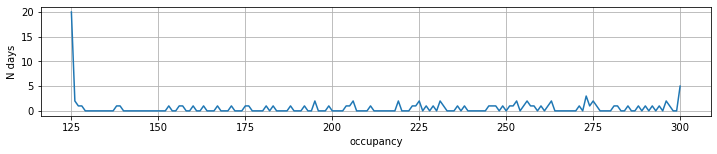

In [11]:
plt.figure(figsize=(12, 2))
plt.plot(init_occupancy_counts); plt.xlabel('occupancy'); plt.ylabel('N days')
plt.ylim(-1, init_occupancy_counts.max()+1); plt.grid(); plt.show()

In [12]:
accounting_cost_per_day = pd.Series({
    day: nd_ndp1_to_account_penality[occupancy[day], occupancy[day+1]].astype('float32')
    for day in days
})

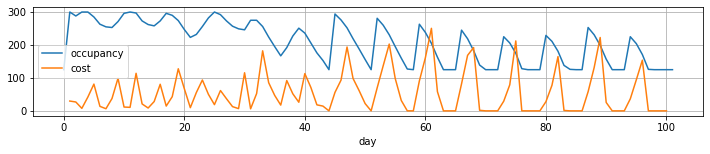

In [13]:
plt.figure(figsize=(12, 2))
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.legend(); plt.grid(); plt.show()

In [14]:
print(max(accounting_cost_per_day), accounting_cost_per_day)

250.48410034179688 1       29.788443
2       26.920185
3        7.577722
4       41.944504
5       81.210869
          ...    
96     153.777359
97       0.030912
98       0.000000
99       0.000000
100      0.000000
Length: 100, dtype: float64


### Family preferred days

In [15]:
day_rank_count = np.zeros((10, N_days+1), dtype='int32')

In [16]:
for r in range(10):
    family_pref_r = family_pref[:, r]
    for day, size in zip(family_pref_r, n_people):
        day_rank_count[r, day] += size

In [17]:
day_rank_count

array([[   0, 1576,  202, ...,   56,   57,   43],
       [   0, 1478,  131, ...,   53,   64,   41],
       [   0, 1337,  168, ...,   48,   39,   62],
       ...,
       [   0, 1053,  201, ...,   70,   34,   71],
       [   0,  830,  217, ...,   38,   41,   73],
       [   0,  845,  158, ...,   54,   69,   56]])

In [18]:
day_rank_acc_count = np.zeros((10, N_days+1), dtype='int32')
for rank_acc in range(10):
    day_rank_acc_count[rank_acc] = day_rank_count[rank_acc]
    for r in range(1, rank_acc + 1):
        day_rank_acc_count[rank_acc] += day_rank_count[r]

In [19]:
day_rank_acc_count

array([[    0,  1576,   202, ...,    56,    57,    43],
       [    0,  2956,   262, ...,   106,   128,    82],
       [    0,  4152,   467, ...,   149,   142,   165],
       ...,
       [    0,  9370,  1430, ...,   491,   398,   496],
       [    0,  9977,  1663, ...,   497,   446,   571],
       [    0, 10837,  1762, ...,   567,   543,   610]])

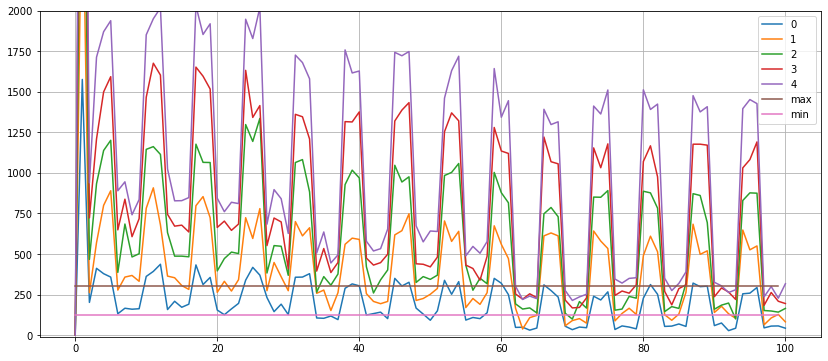

In [20]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.ylim(-10, 2000)
plt.grid(); plt.legend(); plt.show()

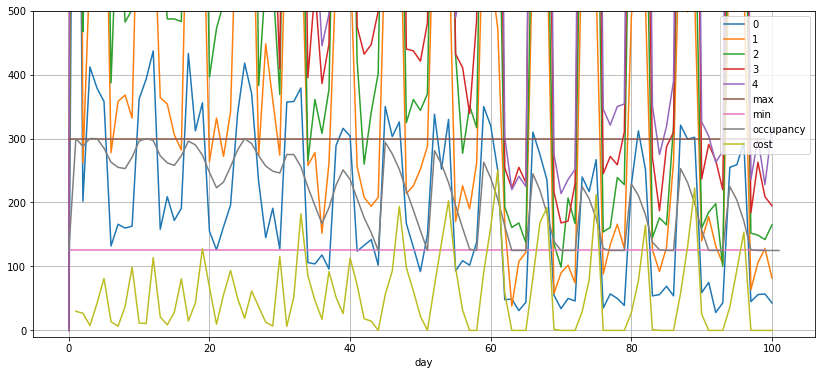

In [21]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

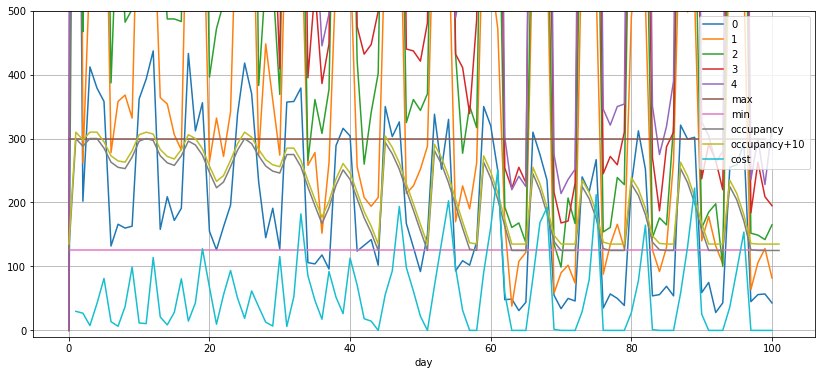

In [22]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(occupancy+occupancy_diff_low, label='occupancy+10')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

## Setup

In [23]:
# limit the occupancy choice to +- occupancy_diff of current solution
search_occupancy = {}
for day in days:
    if day == 1:
        search_occupancy[day] = [N_max_people]
    elif day == N_days:
        search_occupancy[day] = [N_min_people]
    elif occupancy[day] == N_min_people:
        search_occupancy[day] = range(N_min_people, occupancy[day] + occupancy_diff_low + 1)
    else:
        search_occupancy[day] = range(max(occupancy[day] - occupancy_diff, N_min_people),
                                      min(occupancy[day] + occupancy_diff, N_max_people) + 1)

In [24]:
for i, x in search_occupancy.items():
    print(i, x)

1 [300]
2 range(208, 301)
3 range(220, 301)
4 range(220, 301)
5 range(205, 301)
6 range(183, 301)
7 range(175, 301)
8 range(173, 301)
9 range(191, 301)
10 range(216, 301)
11 range(220, 301)
12 range(217, 301)
13 range(193, 301)
14 range(182, 301)
15 range(178, 301)
16 range(193, 301)
17 range(216, 301)
18 range(210, 301)
19 range(194, 301)
20 range(167, 301)
21 range(143, 301)
22 range(152, 301)
23 range(176, 301)
24 range(202, 301)
25 range(220, 301)
26 range(212, 301)
27 range(193, 301)
28 range(177, 301)
29 range(169, 301)
30 range(166, 301)
31 range(195, 301)
32 range(195, 301)
33 range(176, 301)
34 range(144, 301)
35 range(125, 276)
36 range(125, 248)
37 range(125, 273)
38 range(147, 301)
39 range(171, 301)
40 range(156, 301)
41 range(126, 287)
42 range(125, 257)
43 range(125, 234)
44 range(125, 136)
45 range(214, 301)
46 range(196, 301)
47 range(172, 301)
48 range(139, 300)
49 range(125, 269)
50 range(125, 237)
51 range(125, 136)
52 range(201, 301)
53 range(180, 301)
54 range(151

In [25]:
# occupancy pairs [o, o_next] limited by accounting cost
viable_nd_ndp1 = nd_ndp1_to_account_penality <= max_accounting_cost_per_day

In [26]:
viable_nd_ndp1[N_min_people:N_max_people+1, N_min_people:N_max_people+1].sum()

15130

(125, 300)

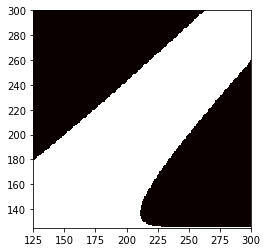

In [27]:
plt.imshow(viable_nd_ndp1, cmap='hot', interpolation='nearest')
plt.xlim(N_min_people, N_max_people)
plt.ylim(N_min_people, N_max_people)

In [28]:
# Possible choice for the family
# last choice is any day that is not on the family's preferred days
N_choices_ori = family_id_choice_to_pref_cost.shape[1]
N_choices = min(N_choices_ori, max_family_rank)
print('Limit family choice rank:', N_choices_ori, '->', N_choices)

Limit family choice rank: 11 -> 6


In [29]:
family_id_choice_to_pref_cost[:, :N_choices]

array([[  0,  50,  86, 136, 236, 272],
       [  0,  50,  86, 136, 236, 272],
       [  0,  50,  77, 127, 227, 254],
       ...,
       [  0,  50, 104, 154, 254, 308],
       [  0,  50,  95, 145, 245, 290],
       [  0,  50,  86, 136, 236, 272]], dtype=int64)

## DOCplex model

In [30]:
from docplex.mp.model import Model

In [31]:
solver = Model('')

In [32]:
if num_cpu_cores > 0:
    solver.context.cplex_parameters.threads = num_cpu_cores
    print('Set num threads:', num_cpu_cores)
print('Num treads:', solver.context.cplex_parameters.threads)
if time_limit > 0:
    print('Set time limit:', solver.set_time_limit(time_limit))

Set num threads: 20
Num treads: threads:int(20)
Set time limit: None


In [33]:
solver.parameters.mip.tolerances.mipgap = 0  # set mip gap to 0

## Variables

In [34]:
# Variables
# assignment matrix[family, pref_rank]
assignment_matrix = solver.binary_var_matrix(families, range(N_choices), 'x')

In [35]:
len(assignment_matrix)

30000

In [36]:
possible_family_sizes = np.unique(n_people)

In [37]:
# unpreferred_day_counts[day, size]
if N_choices_ori <= N_choices:
    print('using unpreferred day counts')
    ub = int(N_max_people / possible_family_sizes.min())
    unpreferred_day_counts = solver.integer_var_matrix(days, possible_family_sizes, lb=0, ub=ub, name='d')
    print(len(unpreferred_day_counts))    

In [38]:
# Occupancy matrix [day, N_d, N_d+1]
occupancy_keys_list = []
for day in days:
    if day < N_days:
        for o in search_occupancy[day]:
            for o_next in search_occupancy[day + 1]:
                if viable_nd_ndp1[o, o_next]:
                    occupancy_keys_list.append((day, o, o_next))
    else:
        # last day
        for o in search_occupancy[day]:
            if viable_nd_ndp1[o, o]:
                occupancy_keys_list.append((day, o))
occupancy_matrix = solver.binary_var_dict(occupancy_keys_list, name='o')

In [39]:
search_occupancy[N_days]

[125]

In [40]:
len(occupancy_matrix)

645835

## Constraints

### constraint 1: each family only take one day (choice)

In [41]:
# Constraints
# constraint 1: each family only take one day (choice)
solver.add_constraints_([
    solver.sum([assignment_matrix[family, c] for c in range(N_choices)]) == 1 
    for family in families
])

### constraint: choices limit

In [42]:
if min_choice_0_families > 0:
    solver.add_constraint_(
        solver.sum([assignment_matrix[family, 0] for family in families]) >= min_choice_0_families
    )

### occupancy counts

In [43]:
# constraint 2: each day can only have 125-300 people

In [44]:
N_family_pref = min(N_choices, N_choices_ori - 1)
N_family_pref

6

In [45]:
# day to dictionary of families who choose this day with value as preference rank
days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

In [46]:
for family, pref in enumerate(family_pref):
    for rank, day in enumerate(pref):
        if rank < N_family_pref:
            days_family_prefered[day][family] = rank

In [47]:
# occupancy count [intermediate variables]

if occupancy_count_as_variables:
    lbs = [min(search_occupancy[day]) for day in days]
    ubs = [max(search_occupancy[day]) for day in days]
    occupancy_counts = solver.integer_var_dict(days, lb=lbs, ub=ubs, name='oc')
    
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        solver.add_constraint_(
            occupancy_counts[day] == (
                solver.sum(
                    [assignment_matrix[family, pref_rank] * n_people[family] 
                     for family, pref_rank in family_prefered.items()]
                ) + (
                    solver.sum(
                        [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                    ) if N_choices >= N_choices_ori else 0
                )
            )
        )
else:
    occupancy_counts = {}
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        occupancy_counts[day] = (
            solver.sum(
                [assignment_matrix[family, pref_rank] * n_people[family] 
                 for family, pref_rank in family_prefered.items()]
            ) + (
                solver.sum(
                    [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                ) if N_choices >= N_choices_ori else 0
            )
        )

In [48]:
if not occupancy_count_as_variables:
    for day in days:
        solver.add_range(min(search_occupancy[day]), 
                         occupancy_counts[day], 
                         max(search_occupancy[day]))

### constraint 3: unpreferred day family count conservation for each family size

In [49]:
# constraint 3: unpreferred day family count conservation for each family size

In [50]:
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

In [51]:
if N_choices >= N_choices_ori:
    solver.add_constraints_([
        solver.sum([assignment_matrix[family, N_choices - 1]
                    for family in family_size_to_family_ids[size]])
        == solver.sum([unpreferred_day_counts[day, size] for day in days])
        for size in possible_family_sizes
    ])

### Occupancy boolean matrix normalization

In [52]:
# occupancy boolean matrix normalization
# each day only take 1 occupancy value
for day in days:
    if day < N_days:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o, o_next] 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o] 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]
        ])
    solver.add_constraint_(occupancy_normalization == 1)

### constrain 4: link occupancy boolean matrix to occupancy count

In [53]:
for day in days:
    if day < N_days:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o, o_next] * o 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o] * o 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]            
        ])
    solver.add_constraint_(occupancy_counts[day] == sum_from_occupancy_matrix)

In [54]:
# next day occupancy consistency
if True:
    # Approach 1: (faster)
    solver.add_constraints_([
        occupancy_counts[day + 1] == solver.sum([
            occupancy_matrix[day, o, o_next] * o_next 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]            
        ])
        for day in days if day < N_days
    ])
else:
    # Approach 2: (much slower)
    for day in days:
        if day + 1 < N_days:
            for o in search_occupancy[day+1]:
                solver.add_constraint_(
                    solver.sum(
                        [occupancy_matrix[day, o_other, o] for o_other in search_occupancy[day] if viable_nd_ndp1[o_other, o]]
                    ) == solver.sum(
                        [occupancy_matrix[day + 1, o, o_other] for o_other in search_occupancy[day+2] if viable_nd_ndp1[o, o_other]]
                    )
                )
    for o in search_occupancy[N_days]:
        solver.add_constraint_(
            solver.sum(
                [occupancy_matrix[N_days - 1, o_other, o] for o_other in search_occupancy[N_days - 1] if viable_nd_ndp1[o_other, o]]
            ) == occupancy_matrix[N_days, o] if viable_nd_ndp1[o, o] else 0
        )

### Preference cost

In [55]:
family_pref_cost = solver.sum([
    assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
    for family in families for c in range(1, N_choices)
])

In [56]:
if target_pref_cost > 0:
    print('limit preference cost')
    if target_pref_cost_error > 0:
        solver.add_constraints_([
            family_pref_cost <= target_pref_cost + target_pref_cost_error,
            family_pref_cost >= target_pref_cost - target_pref_cost_error
        ])
    else:
        solver.add_constraint_(family_pref_cost == target_pref_cost)

### Accounting cost

In [57]:
accounting_cost = (
    solver.sum([
        occupancy_matrix[day, o, o_next] * nd_ndp1_to_account_penality[o, o_next]
        for day in days if day < N_days
        for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next] and o > N_min_people
    ]) +
    solver.sum([
        occupancy_matrix[N_days, o] * nd_ndp1_to_account_penality[o, o]
        for o in search_occupancy[N_days]
        if viable_nd_ndp1[o, o] and o > N_min_people  
    ])
)

In [58]:
if target_accounting_cost > 0:
    if target_accounting_cost_error > 0:
        print('Range limit accounting cost')
        solver.add_range(
            target_accounting_cost - target_accounting_cost_error,
            accounting_cost,
            target_accounting_cost - target_accounting_cost_error
        )
elif target_accounting_cost_lower > 0:
    print('Lower bound accounting cost')
    solver.add_constraint_(accounting_cost >= target_accounting_cost_lower)

Lower bound accounting cost


In [59]:
#accounting_cost.GetCoeffs()[occupancy_matrix[100, 128]]

## Objective

In [60]:
# Objective - Preference cost only as approximation
solver.minimize(family_pref_cost + accounting_cost)  # family_pref_cost + 

## Hint

In [61]:
if use_hint:
    print('Using hint!')

    from docplex.mp.solution import SolveSolution
    var_value_map = {}
    
    for family in families:
        for c in range(N_choices):
            var_value_map[assignment_matrix[family, c]] = float(
                assigned_day[family] == family_pref[family, c]
            )
    for day in days:
        if day < N_days:
            for o in search_occupancy[day]:
                for o_next in search_occupancy[day + 1]:
                    if viable_nd_ndp1[o, o_next]:
                        var_value_map[occupancy_matrix[day, o, o_next]] = float(
                            (occupancy[day] == o) and (occupancy[day + 1] == o_next)
                        )
                    else:
                        assert not ((occupancy[day] == o) and (occupancy[day + 1] == o_next)), \
                        'Hint not valid at (%i, %i, %i)'%(day, o, o_next)
    for o in search_occupancy[N_days]:
        if viable_nd_ndp1[o, o]:
            var_value_map[occupancy_matrix[N_days, o]] = float(occupancy[N_days] == o)
        else:
            assert not (occupancy[N_days] == o), \
            'Hint not valid at (%i, %i, %i)'%(N_days, o, o)

    if occupancy_count_as_variables:
        for day in days:
            var_value_map[occupancy_counts[day]] = float(occupancy[day])
    
    init_solution = SolveSolution(solver, var_value_map)
    solver.add_mip_start(init_solution)

Using hint!


## Solve

In [62]:
from docplex.mp.progress import TextProgressListener
from docplex.mp.progress import ProgressClock
from docplex.mp.progress import SolutionRecorder

See http://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.progress.html#docplex.mp.progress.ProgressClock for progress clock parameters meaning

In [63]:
class MyProgressListener(SolutionRecorder):
    def __init__(self, clock=ProgressClock.Gap, absdiff=None, reldiff=None):
        super(MyProgressListener, self).__init__(clock, absdiff, reldiff)
        self.current_objective = initial_score or 999999
        
    def notify_solution(self, sol):
        if self.current_progress_data.current_objective >= self.current_objective:
            return
        print ('Improved solution')
        super(MyProgressListener, self).notify_solution(sol)
        self.current_objective = self.current_progress_data.current_objective
        assigned_day_new_raw = np.ones(N_families, dtype='int32') * -1
        for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
            assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1
        solution = pd.DataFrame(data=families, columns = ['family_id'])
        solution['assigned_day'] = assigned_day_new_raw
        #score = cost_function(preds)
        #print('Score: ' + str(score))        
        solution.to_csv(path_dump_improved, index=False)
        
    def get_solutions(self):
        return self._solutions

In [64]:
# print progress
my_progress_listener = MyProgressListener(clock=ProgressClock.Gap)
solver.add_progress_listener(
#     TextProgressListener(clock=ProgressClock.Gap)
    my_progress_listener
)  
# clock=ProgressClock.Objective, absdiff=10
# ProgressClock.All

In [65]:
print('N of variables (binary, int):', solver.number_of_variables, 
      '(', solver.number_of_binary_variables, ',', solver.number_of_integer_variables, ')')
print('N of constraints:', solver.number_of_constraints)
print('Time limit:', solver.get_time_limit())

N of variables (binary, int): 675935 ( 675835 , 100 )
N of constraints: 5401
Time limit: 518400.0


In [ ]:
%%time
# Solve
sol = solver.solve(log_output=True)

if sol is None:
    sol = my_progress_listener.get_solutions()[-1]

print('Solution status:', solver.get_solve_status())
print('Total cost:', sol.objective_value, sol.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 20
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               518400
CPXPARAM_MIP_Tolerances_MIPGap                   0
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 69712.4200.
Tried aggregator 1 time.
MIP Presolve eliminated 4 rows and 3 columns.
MIP Presolve modified 488302 coefficients.
Reduced MIP has 5397 rows, 675932 columns, and 2645587 nonzeros.
Reduced MIP has 675834 binaries, 98 generals, 0 SOSs, and 0 indicators.
Presolve time = 2.66 sec. (2806.83 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 5397 rows, 675932 columns, and 2645587 nonzeros.
Reduced MIP has 675834 binaries, 98 generals, 0 SOSs, and 0 indicators.
Presolve time = 2.24 sec. (1329.00 ticks)
Probing time = 0.77 sec. (389.49 ticks)
Clique ta

    202   167    68867.8243   650    69712.4200    68831.8162    61972    1.26%
Elapsed time = 852.06 sec. (1215635.53 ticks, tree = 21.76 MB, solutions = 1)
    206   155    68884.6341   528    69712.4200    68831.8162    60053    1.26%
    210   157    68869.9115   510    69712.4200    68831.8162    60116    1.26%
    213   181    69093.9777   443    69712.4200    68831.8162    64883    1.26%
    223   187    68859.5300   550    69712.4200    68831.8162    66712    1.26%
    231    69    69002.8222   618    69712.4200    68831.8162    41508    1.26%
    240   178    68859.4154   649    69712.4200    68831.8162    63803    1.26%
    245   195    68879.8086   627    69712.4200    68831.8162    67909    1.26%
    248   185    68861.3392   589    69712.4200    68831.8162    65485    1.26%
    253   188    68877.2886   613    69712.4200    68831.8162    67188    1.26%
    265   191    68863.2592   610    69712.4200    68831.8162    67591    1.26%
Elapsed time = 885.45 sec. (1227271.13 tic

   8247  6784    69073.2070   146    69712.4200    68831.8162   457691    1.26%
   8478  6810    69090.8071   152    69712.4200    68831.8162   458387    1.26%
   8687  7659    69309.6224   112    69712.4200    68831.8162   494934    1.26%
   8873  7684    69334.0988   108    69712.4200    68831.8162   495660    1.26%
   9015  7448    69360.3833   108    69712.4200    68831.8162   474963    1.26%
   9172  7909    69697.2310   112    69712.4200    68831.8162   501881    1.26%
   9328  8185    69106.9671   163    69712.4200    68831.8162   512239    1.26%
   9460  7875    69254.9859   110    69712.4200    68831.8162   499621    1.26%
Elapsed time = 1523.44 sec. (1492678.03 ticks, tree = 2162.89 MB, solutions = 1)
Nodefile size = 65.58 MB (14.72 MB after compression)
   9591  8573    69285.4533   112    69712.4200    68831.8162   527584    1.26%
   9756  8352    69259.2399   105    69712.4200    68831.8162   517004    1.26%
   9888  8626    69337.9049   102    69712.4200    68831.8162   5

  11912   652    69301.7748   778    69712.4200    68874.6664   657864    1.20%
  11992   828    69609.0750   660    69712.4200    68874.6780   667516    1.20%
  12085   927    69608.9332   680    69712.4200    68874.7194   668063    1.20%
  12219   868    69609.0858   662    69712.4200    68874.7476   667607    1.20%
  12338   990    69633.7936   649    69712.4200    68874.7679   670610    1.20%
  12428  1153    69612.7321   673    69712.4200    68874.7679   678192    1.20%
  12568  1004    69639.3427   571    69712.4200    68874.7679   672240    1.20%
Elapsed time = 2788.24 sec. (3230877.14 ticks, tree = 187.32 MB, solutions = 1)
  12693  1252    69633.8952   647    69712.4200    68874.7679   681018    1.20%
  12824  1305    69639.3963   560    69712.4200    68874.7679   681863    1.20%
  12940  1263    69658.8108   618    69712.4200    68874.7679   679182    1.20%
  13095  1367    69626.8742   637    69712.4200    68874.7679   685661    1.20%
  13262  1524    69628.7772   622    697

  22676  7258    infeasible          69712.4200    68874.8300   883008    1.20%
  22750  7369    69649.8302   746    69712.4200    68874.8300   885314    1.20%
  22766  7208    69706.1574   774    69712.4200    68874.8300   883730    1.20%
Elapsed time = 3697.72 sec. (3715578.58 ticks, tree = 1652.98 MB, solutions = 1)
  22801  7398    69664.4313   538    69712.4200    68874.8300   889435    1.20%
  22839  7392    69707.5248   789    69712.4200    68874.8300   889493    1.20%
  22919  7409    69504.7023   789    69712.4200    68874.8300   890686    1.20%
  23011  7365    69568.7689   788    69712.4200    68874.8300   889215    1.20%
  23100  7468    69707.7353   756    69712.4200    68874.8300   890127    1.20%
  23196  7507        cutoff          69712.4200    68874.8300   895577    1.20%
  23272  7506    69626.8055   732    69712.4200    68874.8300   894197    1.20%
  23327  7687    69664.4786   534    69712.4200    68874.8300   900207    1.20%
  23376  7692    69664.4943   525    69

  31822 13780    69315.4274   768    69712.4200    68874.8300  1057608    1.20%
  31923 13756    69371.4129   760    69712.4200    68874.8300  1057642    1.20%
  32055 13744    69488.4900   681    69712.4200    68874.8300  1057741    1.20%
Elapsed time = 4339.86 sec. (4062403.57 ticks, tree = 3266.04 MB, solutions = 1)
Nodefile size = 1194.99 MB (330.84 MB after compression)
  32186 13754    69489.2136   657    69712.4200    68874.8300  1057992    1.20%
  32309 13532    69698.2583   600    69712.4200    68874.8300  1053928    1.20%
  32441 13811    69371.9379   770    69712.4200    68874.8300  1058375    1.20%
  32572 14171    69371.9594   768    69712.4200    68874.8300  1065060    1.20%
  32717 14209    69371.9614   768    69712.4200    68874.8300  1065103    1.20%
  32900 14268    69513.0491   743    69712.4200    68874.8300  1069863    1.20%
  33105 14491    69648.8017   638    69712.4200    68874.8300  1075451    1.20%
  33261 14063    69707.5937   513    69712.4200    68874.8300 

  42984 21506    69518.7777   729    69712.4200    68874.8300  1281199    1.20%
  43126 21340    69500.0664   685    69712.4200    68874.8300  1269407    1.20%
  43238 21360    69500.0670   685    69712.4200    68874.8300  1269430    1.20%
  43338 21533        cutoff          69712.4200    68874.8300  1286516    1.20%
  43435 21636    69414.7153   669    69712.4200    68874.8300  1287388    1.20%
  43566 21869    69399.5547   774    69712.4200    68874.8300  1292605    1.20%
Elapsed time = 5077.72 sec. (4408665.89 ticks, tree = 5259.56 MB, solutions = 1)
Nodefile size = 3197.22 MB (890.76 MB after compression)
  43680 21765    69500.3831   670    69712.4200    68874.8300  1289373    1.20%
  43794 21676    69414.7393   657    69712.4200    68874.8300  1287507    1.20%
  43905 21928    69371.8341   763    69712.4200    68874.8300  1296452    1.20%
  44016 21832    69500.4400   666    69712.4200    68874.8300  1289580    1.20%
  44139 22027    69420.1470   705    69712.4200    68874.8300 

  54205 29718    69694.9021   650    69712.4200    68874.8300  1498000    1.20%
  54411 29752    69400.2220   760    69712.4200    68874.8300  1503012    1.20%
  54556 29300    69506.7512   587    69712.4200    68874.8300  1481598    1.20%
  54697 29310    69506.9361   569    69712.4200    68874.8300  1481858    1.20%
  54853 29714    69626.3008   601    69712.4200    68874.8300  1485473    1.20%
  55028 30440    69487.7293   675    69712.4200    68874.8300  1523107    1.20%
  55211 29696    69400.3030   774    69712.4200    68874.8300  1497088    1.20%
  55338 30461    69496.3791   660    69712.4200    68874.8300  1523579    1.20%
  55468 30138    69507.2624   575    69712.4200    68874.8300  1519459    1.20%
Elapsed time = 5866.28 sec. (4754707.46 ticks, tree = 7259.34 MB, solutions = 1)
Nodefile size = 5173.11 MB (1442.14 MB after compression)
  55564 30019    69463.9426   686    69712.4200    68874.8300  1518055    1.20%
  55665 30172    69507.4107   599    69712.4200    68874.8300

Elapsed time = 6702.28 sec. (5065523.95 ticks, tree = 8726.89 MB, solutions = 1)
Nodefile size = 6647.01 MB (1847.38 MB after compression)
  61913 35557    69474.9734   702    69712.4200    68874.8300  1697098    1.20%
  61993 35587    69474.9738   702    69712.4200    68874.8300  1697139    1.20%
  62045 35616    69474.9795   704    69712.4200    68874.8300  1697182    1.20%
  62073 35721    69539.1604   676    69712.4200    68874.8300  1703888    1.20%
  62089 35725    69539.1632   676    69712.4200    68874.8300  1704205    1.20%
  62101 35728    69543.5618   682    69712.4200    68874.8300  1704625    1.20%
  62124 35874    69509.4540   665    69712.4200    68874.8300  1709523    1.20%
  62139 35886    69509.5894   682    69712.4200    68874.8300  1709701    1.20%
  62165 36056    69355.7671   775    69712.4200    68874.8300  1709519    1.20%
  62179 36339    69313.9508   777    69712.4200    68874.8300  1719778    1.20%
Elapsed time = 6765.44 sec. (5106059.62 ticks, tree = 8917.59

  70032 42045    69689.4415   538    69712.4200    68874.8300  1881954    1.20%
  70135 42194    69691.3269   681    69712.4200    68874.8300  1906569    1.20%
  70282 42043    69703.9753   648    69712.4200    68874.8300  1894692    1.20%
Elapsed time = 7434.92 sec. (5414341.33 ticks, tree = 10191.38 MB, solutions = 1)
Nodefile size = 8121.84 MB (2254.78 MB after compression)
  70396 42286    69702.7229   698    69712.4200    68874.8300  1909580    1.20%
  70541 41287    69672.2325   702    69712.4200    68874.8300  1868138    1.20%
  70686 42707    69365.3991   740    69712.4200    68874.8300  1913490    1.20%
  70862 42490    69514.9742   646    69712.4200    68874.8300  1912227    1.20%
  71041 42362    69709.9781   680    69712.4200    68874.8300  1911652    1.20%
  71185 42251    69479.9763   647    69712.4200    68874.8300  1894591    1.20%
  71335 42762    69704.4916   621    69712.4200    68874.8300  1916380    1.20%
  71475 42502        cutoff          69712.4200    68874.830

## Solution

In [ ]:
assigned_day_new_raw = np.ones(assigned_day.shape, dtype='int32') * -1
for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
    assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1

In [ ]:
assigned_day_new_raw

In [ ]:
if N_choices >= N_choices_ori:
    unpreferred_day_counts_sol_dict = sol.get_value_dict(unpreferred_day_counts)
    unpreferred_day_counts_sol = {
        size: [0]+[int(unpreferred_day_counts_sol_dict[day, size]) for day in days]
        for size in possible_family_sizes
    }

    print('Unpreferred families slots:')
    {size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()}

In [ ]:
def distribute_unpreferred_day(assigned_day, unpreferred_day_counts_sol, n_people):
    """ Distribute unpreferred day to each family who has -1 day assigned """
    assigned_day = assigned_day.copy()
    unpreferred_days = {size: [] for size in possible_family_sizes}
    for size in possible_family_sizes:
        for day, quota in enumerate(unpreferred_day_counts_sol[size]):
            unpreferred_days[size] = unpreferred_days[size] + [day] * quota
    unpreferred_day_headers = {size: 0 for size in possible_family_sizes}
    for family, (day, size) in enumerate(zip(assigned_day, n_people)):
        if day == -1:
            assigned_day[family] = unpreferred_days[size][unpreferred_day_headers[size]]
            unpreferred_day_headers[size] += 1
    return assigned_day

In [ ]:
if N_choices >= N_choices_ori:
    assigned_day_new = distribute_unpreferred_day(assigned_day_new_raw, unpreferred_day_counts_sol, n_people)
else:
    assigned_day_new = assigned_day_new_raw

In [ ]:
print('N family unpreferred assigned:', (~(assigned_day_new == assigned_day_new_raw)).sum())

In [ ]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
occupancy_new = assigned_day_to_occupancy(assigned_day_new)

In [ ]:
try:
    is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
except:
    is_valid = False
new_score = cal_total(assigned_day_new, occupancy_new)
print('Valid solution: ', is_valid)
print('Total score:    ', new_score, '(', new_score - initial_score, ')')
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

## Output

In [ ]:
is_improved = new_score < initial_score
if is_valid and (is_improved or (path_dump_improved != path_init_conf)):
    print('output to', path_dump_improved)
    dump_conf(assigned_day_new, path_dump_improved)

## Debug

In [ ]:
# [
#     [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
#     for family in range(10)
# ]        

In [ ]:
# if N_choices >= N_choices_ori:
#     print([
#         [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
#         for day in range(1, 10)
#     ])